<a href="https://colab.research.google.com/github/grace3999/BB_projects/blob/master/MouseOx_Awake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string
import scipy

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', None)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Get and clean data

In [21]:
meta_path =  '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/MouseOx_pilot_meta.xlsx'

data_meta = pd.read_excel(meta_path) 
data_meta = pd.DataFrame(data = data_meta)

#data_meta['animal'] = data_meta['animal'].astype(int).astype('str')
#data_meta['day'] = data_meta['day'].astype('str')
#data_meta['date'] = data_meta['date'].dt.date

print(data_meta.shape)
print(data_meta.info())
data_meta.tail()

(15, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Cage       15 non-null     object 
 1   Group      15 non-null     int64  
 2   Animal     15 non-null     int64  
 3   PSI_1      8 non-null      float64
 4   PSI_2      8 non-null      float64
 5   PSI_3      9 non-null      float64
 6   PSI_mean   9 non-null      float64
 7   LORR_1     9 non-null      float64
 8   LORR_2     9 non-null      float64
 9   LORR_3     9 non-null      float64
 10  LORR_mean  1 non-null      float64
 11  wt_2_bl%   15 non-null     float64
 12  wt_3_bl%   15 non-null     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 1.6+ KB
None


,Cage,Group,Animal,PSI_1,PSI_2,PSI_3,PSI_mean,LORR_1,LORR_2,LORR_3,LORR_mean,wt_2_bl%,wt_3_bl%
10,SA348,5,1291,18.34,17.43,14.93,16.900000,24.0,62.0,68.0,NaN,-4.059041,-4.059041
11,SA348,5,1292,17.58,18.09,18.93,18.200000,45.0,187.0,158.0,NaN,-6.620209,-5.226481
12,SA349,5,1293,18.81,20.00,18.74,19.183333,92.0,76.0,250.0,NaN,-2.230483,0.371747
13,SA349,5,1294,NaN,20.53,17.39,18.960000,140.0,105.0,173.0,NaN,-7.987220,-7.028754
14,SA349,5,1295,17.81,20.57,19.75,19.376667,149.0,91.0,86.0,NaN,-5.882353,-3.308824


In [4]:
path = '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr'

files = os.listdir(path)

data_file_paths = []
for file in files:
    file_path = path + '/' + file
    data_file_paths.append(file_path)

print(len(data_file_paths))
data_file_paths[0:5]

5


['/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA345_awake.txt',
 '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA346_awake.txt',
 '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA347_awake.txt',
 '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA348_awake.txt',
 '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA349_awake.txt']

In [6]:
final_data = pd.DataFrame()

for file in data_file_paths:
    print(file)
    
    if file.split('/')[-1] == '.DS_Store':
        continue
     
    #get file meta data
    tp = file.split('/')[-1].split('_')[0]
    cage = file.split('/')[-1].split('_')[1]

    #make dataframe
    data_int = pd.read_table(file, sep=',') 
    data_int = pd.DataFrame(data = data_int)

    #drop un used columns
    data_int = data_int.drop(['Core', '15Hz'], axis=1)
    
    #update columns names
    data_int.columns = ['time_sec', 'animal', 'animal_count', 'file_marker', 'error_code', 
                        'O2_sat', 'hr_bpm', 'br_brpm', 'pd_um', 'bd_um', 'activity', 'datetime']
    
    #drop rows with param meta data
    data_int = data_int.drop([0, 1], axis=0)

    #add meta data
    data_int['cage'] = cage
    data_int['tp'] = tp

    #update dtypes and clean
    data_float = data_int[['animal', 'animal_count', 'time_sec', 'file_marker', 'error_code', 'O2_sat', 'hr_bpm',
       'br_brpm', 'pd_um', 'bd_um', 'activity',]].astype('float')
    data_int = pd.concat([data_int[['datetime', 'cage', 'tp']], data_float], axis=1)
    data_int['datetime'] = pd.to_datetime(data_int['datetime'])

    #merge with meta data
    data_int = data_meta.merge(data_int, left_on=['Animal'], right_on=['animal'])

    #combine into one final df
    if final_data.empty:
        final_data = data_int
    else:
        final_data = pd.concat([final_data, data_int], axis=0)
        
    print(final_data.shape,'\n')

#cols = ['O2_sat', 'hr_bpm', 'br_brpm', 'pd_um', 'bd_um', 'activity',]
#final_data[cols] = final_data[cols].replace({0:np.nan})

final_data.head()

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA345_awake.txt
(14780, 27) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA346_awake.txt
(29120, 27) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA347_awake.txt
(43360, 27) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA348_awake.txt
(57780, 27) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MouseOx_Pilot/Pilot_96hr/96hr_SA349_awake.txt
(72360, 27) 



,Cage,Group,Animal,PSI_1,PSI_2,PSI_3,PSI_mean,LORR_1,LORR_2,LORR_3,LORR_mean,wt_2_bl%,wt_3_bl%,datetime,cage,tp,animal,animal_count,time_sec,file_marker,error_code,O2_sat,hr_bpm,br_brpm,pd_um,bd_um,activity
0,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
final_final_data =pd.DataFrame()

#make running time column
print(final_data['animal'].unique())

for animal in final_data['animal'].unique():
  print(animal)
  data_animal = final_data[final_data['animal'] == animal]
  data_animal['time'] = np.arange(0,data_animal.shape[0])

  if final_final_data.empty:
    final_final_data = data_animal
  else:
    final_final_data = pd.concat([final_final_data, data_animal], axis=0)
        
  print(final_final_data.shape,'\n')

final_final_data.head()  

[1281. 1282. 1283. 1284. 1285. 1286. 1287. 1288. 1289. 1290. 1291. 1292.
 1293. 1294. 1295.]
1281.0
(5696, 28) 

1282.0
(9821, 28) 

1283.0
(14780, 28) 

1284.0
(18327, 28) 

1285.0
(23650, 28) 

1286.0
(29120, 28) 

1287.0
(33887, 28) 

1288.0
(39059, 28) 

1289.0
(43360, 28) 

1290.0
(47620, 28) 

1291.0
(55318, 28) 

1292.0
(57780, 28) 

1293.0
(60184, 28) 

1294.0
(68221, 28) 

1295.0
(72360, 28) 



,Cage,Group,Animal,PSI_1,PSI_2,PSI_3,PSI_mean,LORR_1,LORR_2,LORR_3,LORR_mean,wt_2_bl%,wt_3_bl%,datetime,cage,tp,animal,animal_count,time_sec,file_marker,error_code,O2_sat,hr_bpm,br_brpm,pd_um,bd_um,activity,time
0,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,SA345,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,2021-04-06 13:13:17,SA345,96hr,1281.0,1.0,0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


### viz/drop data that is 'unsure'

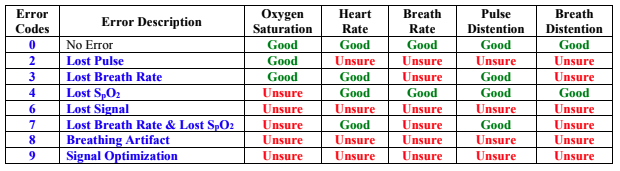

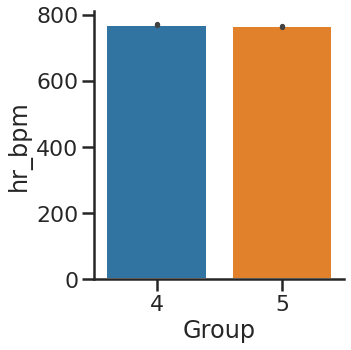

In [8]:
bad_codes = [2,6,8,9 ]
final_data_noerror = final_final_data[~final_final_data['error_code'].isin(bad_codes)]
final_data_noerror = final_final_data[final_final_data['error_code']==0]

#drop rows with 0 for hr_bpm
final_data_noerror = final_data_noerror[final_data_noerror['hr_bpm']>650]

sns.catplot(x='Group', y='hr_bpm', data=final_data_noerror, kind='bar', )

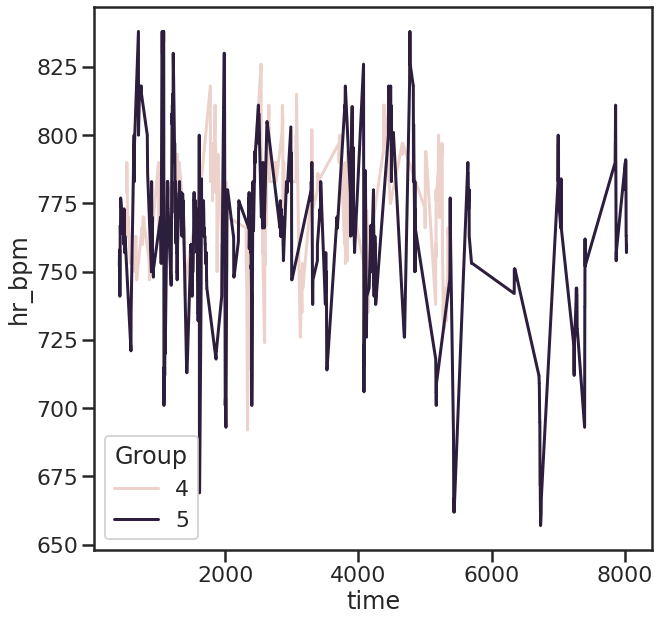

In [119]:
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='time', y='hr_bpm', data=final_data_noerror, hue='Group', ci=None)
plt.show()

In [15]:
final_data_noerror.columns.values
final_data_noerror_mean = final_data_noerror.groupby(['Group', 'Animal']).mean().reset_index()
final_data_noerror_mean

,Group,Animal,PSI_1,PSI_2,PSI_3,PSI_mean,LORR_1,LORR_2,LORR_3,LORR_mean,wt_2_bl%,wt_3_bl%,animal,animal_count,time_sec,file_marker,error_code,O2_sat,hr_bpm,br_brpm,pd_um,bd_um,activity,time
0,4,1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.714286,-1.428571,1281.0,1.0,546.880189,0.0,0.0,95.989623,786.226415,261.066038,358.451887,0.0,0.726415,4077.905660
1,4,1282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.459854,-0.364964,1282.0,2.0,561.780000,0.0,0.0,90.831579,769.242105,193.068421,325.324211,0.0,0.742105,2096.094737
2,4,1283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.355872,-2.491103,1283.0,3.0,522.773913,0.0,0.0,97.086957,759.021739,180.489130,322.131522,0.0,0.869565,2694.336957
3,4,1284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.171875,1.562500,1284.0,1.0,403.672973,0.0,0.0,94.234054,776.978378,259.145946,363.961622,0.0,0.805405,1624.891892
4,4,1285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.492537,2.238806,1285.0,2.0,583.855990,0.0,0.0,89.734896,768.307292,184.619792,294.993229,0.0,0.635417,4257.427083
5,4,1286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.090909,0.363636,1286.0,3.0,681.956179,0.0,0.0,96.779675,754.837398,201.211382,279.386992,0.0,0.512195,3467.162602
6,5,1287,17.85,18.99,18.08,18.306667,300.0,234.0,180.0,238.0,-6.617647,-4.411765,1287.0,1.0,228.247739,0.0,0.0,94.305053,766.247340,173.319149,477.153457,0.0,0.840426,2131.481383
7,5,1288,17.36,18.46,17.97,17.930000,110.0,54.0,117.0,NaN,-2.675585,-2.341137,1288.0,2.0,556.520139,0.0,0.0,92.751389,780.222222,183.666667,349.763889,0.0,0.875000,3383.388889
8,5,1289,20.63,NaN,18.33,19.480000,60.0,79.0,156.0,NaN,-6.462585,-3.061224,1289.0,3.0,766.390361,0.0,0.0,97.284337,781.024096,171.783133,288.159036,0.0,0.939759,3104.409639
9,5,1290,20.36,18.46,19.77,19.530000,76.0,150.0,257.0,NaN,-7.357860,-5.351171,1290.0,1.0,620.391942,0.0,0.0,98.323741,767.870504,188.230216,420.109353,0.0,1.000000,3153.913669


<Figure size 1080x2160 with 0 Axes>

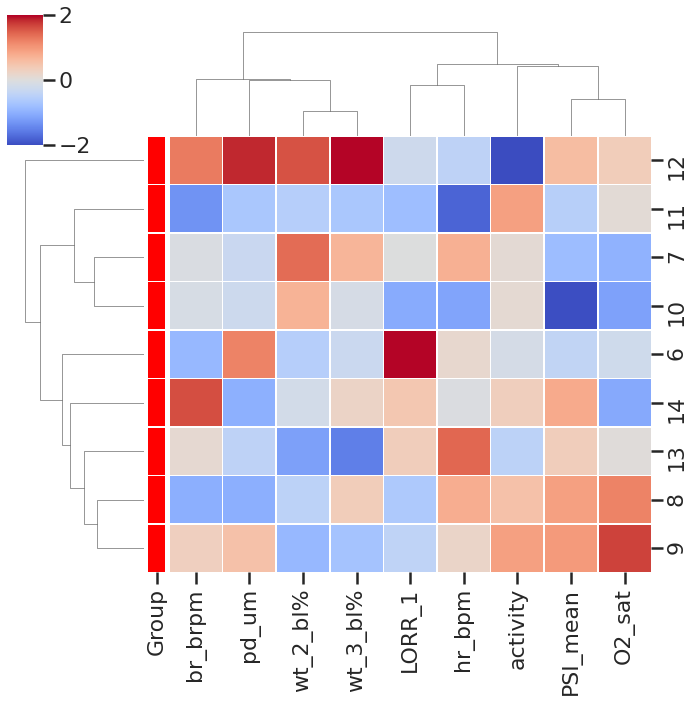

In [22]:
sns.color_palette("flare", as_cmap=True)
params = ['PSI_mean', 'LORR_1', 'wt_2_bl%', 'wt_3_bl%',
          'O2_sat', 'hr_bpm', 'br_brpm',
          'pd_um', 'activity',]

lut = dict(zip(final_data_noerror_mean['Group'].unique(), "br"))
row_colors = final_data_noerror_mean['Group'].map(lut)
plt.figure(figsize=(15,30))

g = sns.clustermap(final_data_noerror_mean[params].dropna(axis=0), row_colors=row_colors,
                 metric="euclidean", z_score=1, method="ward",
               vmin=-2, vmax=2, center=0, cmap = 'coolwarm', 
               square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()